# Import Libraries

In [2]:
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt

# PyTorch Implementation

In [ ]:
def basic_iterative_method(model, input_image, target_label, epsilon, alpha, num_iterations):
    input_image = input_image.clone().detach().requires_grad_(True)
    target_label = target_label.clone().detach()
    adversarial_image = input_image.clone().detach().requires_grad_(True)

    for i in range(num_iterations):
        predictions = model(adversarial_image)
        loss = nn.CrossEntropyLoss()(predictions, target_label)

        model.zero_grad()
        loss.backward()

        gradients = adversarial_image.grad.data
        perturbation = alpha * torch.sign(gradients)
        adversarial_image.data = adversarial_image.data + perturbation
        perturbation = torch.clamp(adversarial_image.data - input_image.data, -epsilon, epsilon)
        adversarial_image.data = input_image.data + perturbation
        adversarial_image.data = torch.clamp(adversarial_image.data, 0.0, 1.0)

    return adversarial_image.detach(), perturbation.detach()

# TensorFlow Implementation

In [21]:
def basic_iterative_method(input_image, target_label, epsilon, alpha, num_iterations):
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    target_label = tf.convert_to_tensor(target_label, dtype=tf.float32)

    adversarial_image = tf.Variable(input_image)

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            predictions = model(adversarial_image)
            loss = tf.keras.losses.categorical_crossentropy(target_label, predictions)

        gradients = tape.gradient(loss, adversarial_image)
        signed_gradients = tf.sign(gradients)
        adversarial_image.assign_add(alpha * signed_gradients)

        perturbation = tf.clip_by_value(adversarial_image - input_image, -epsilon, epsilon)
        adversarial_image.assign(input_image + perturbation)
        adversarial_image.assign(tf.clip_by_value(adversarial_image, 0.0, 1.0))

    return adversarial_image.numpy(), perturbation.numpy()

# Load Data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Load Model

In [7]:
model = tf.keras.models.load_model("models/cifar10_safe_model.h5")

# Attack

In [258]:
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck"]

In [275]:
idx = 3
x_sample = x_test[idx:idx+1]
y_sample = y_test[idx:idx+1]

In [276]:
y_target = np.zeros((1,10,), dtype=np.float32)
y_target[0, 3] = 1

In [277]:
# "ship" -> "truck"
y_sample, y_target

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [313]:
epsilon = 0.3
alpha = 0.005
num_iterations = 100

In [314]:
perturbed_sample, perturbation = basic_iterative_method(x_sample, y_target, epsilon, alpha, num_iterations)

In [315]:
original_image = x_sample[0, :, :, :]
perturbation_image = perturbation[0, :, :, :]
perturbed_image = perturbed_sample[0, :, :, :]

In [316]:
original_pred = np.argmax(model.predict(x_sample, verbose=False), axis=1)
perturbed_pred = np.argmax(model.predict(perturbed_sample, verbose=False), axis=1)

print(f"Prediction before attack: {original_pred}")
print(f"Prediction after attack: {perturbed_pred}")

Prediction before attack: [0]
Prediction after attack: [0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005..0.005].


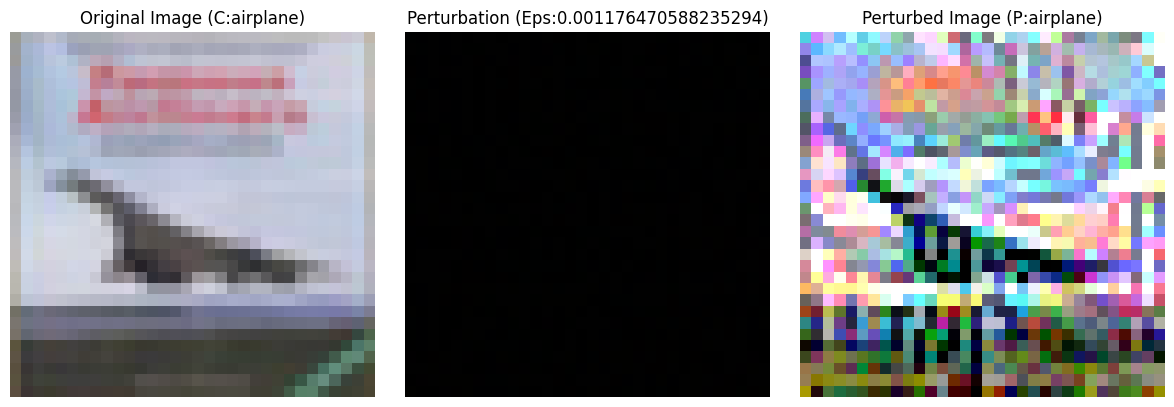

In [317]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title(f"Original Image (C:{cifar10_class_names[original_pred[0]]})")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Perturbation (Eps:{epsilon / 255})")
plt.imshow(perturbation_image)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Perturbed Image (P:{cifar10_class_names[perturbed_pred[0]]})")
plt.imshow(perturbed_image)
plt.axis("off")

plt.tight_layout()
plt.show()